In [1]:
import tensorflow.keras as keras
keras.__version__

"""
Allocate only as much GPU memory as needed for the runtime allocations.
"""
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Inspired by TensorFlow Official tutorial https://www.tensorflow.org/tutorials/generative/style_transfer

# Neural style transfer

Neural style transfer consists of applying the `style` of a reference image to a target image while conserving the `content` of the target image.

`Style` here means textures, colors, and visual patterns in the image, at various spatial scale; and the `content` is the higher-level macrostructure of the image.

Deep convolutional neural networks offer a way to mathematically define content and style, then an appropriate loss function to minimize the loss function defined as:

- Original_image (aka content_image) -- provides content, i.e., a building
- Style_reference_image (aka style_image) -- provide textures, colors, i.e., a Van Gogh painting
- Generated_image -- content from Original_image + style from Style_reference_image

> loss = distance(STYLE(reference_image) - STYLE(generated_image)) +   
>        distance(CONTENT(original_image) - CONTENT(generated_image))

## The content loss

As you already know, activations from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global, abstract information. 

The `content` of an image, which is more global and abstract, is `captured by the representations of the upper layers` (i.e., layers closer to output) in a convnet. A good candidate for `content loss` is thus the L2 norm between 

- the activations of an upper layer in a pretrained convnet, computed over the target image, and 
- the activations of the same layer computed over the Generated_image.

## The style loss

For the `style loss`, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These feature correlations capture the `statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance of the textures found at this scale`.

Hence the `style loss` aims at preserving similar internal correlations within the activations of different layers, across the Style_reference_image and the Generated_image. In turn, this guarantees that the textures found at different spatial scales will look similar across the style reference image and the generated image.

## In short

In short, we can use a pre-trained convnet to define a loss that will:

- Preserve `content` by maintaining similar high-level layer activations between the target content image and the generated image. 
    - The convnet should "see" both the target image and the generated image as "containing the same things".
- Preserve `style` by maintaining similar correlations within activations for both low-level layers and high-level layers. 
    - Indeed, feature correlations capture textures: the generated and the style reference image should share the same textures at different spatial scales.

Now let's take a look at a Keras implementation of the original 2015 neural style transfer algorithm. As you will see, it shares a lot of similarities with the Deep Dream implementation we developed in the previous section.


## Implementing neural style transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. This time we'll use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16 net- work introduced in chapter 5, with three more convolutional layers. This is the general process:

1. Set up a network that computes VGG19 layer activations for the style-reference image, the target image, and the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss function described earlier, which you’ll minimize in order to achieve style transfer.
3. Set up a gradient-descent process to minimize this loss function.



## Import and Setup content_image and style_image

In [2]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
MAX_DIM = 512
content_path = 'axolotl.jpg'
style_path = 'warhol.jpg'

# Get an image and read it into a NumPy array.
def get_image(path_to_img, max_dim=MAX_DIM):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(image, title=None):
    plt.clf()
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# Transform a tensor to an image
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]   
    return PIL.Image.fromarray(tensor)

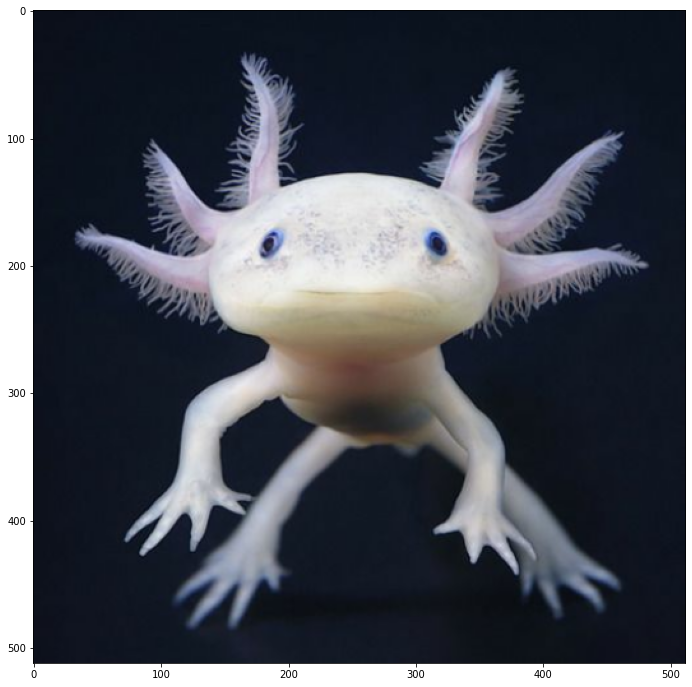

In [4]:
content_image = get_image(content_path)
show(content_image)

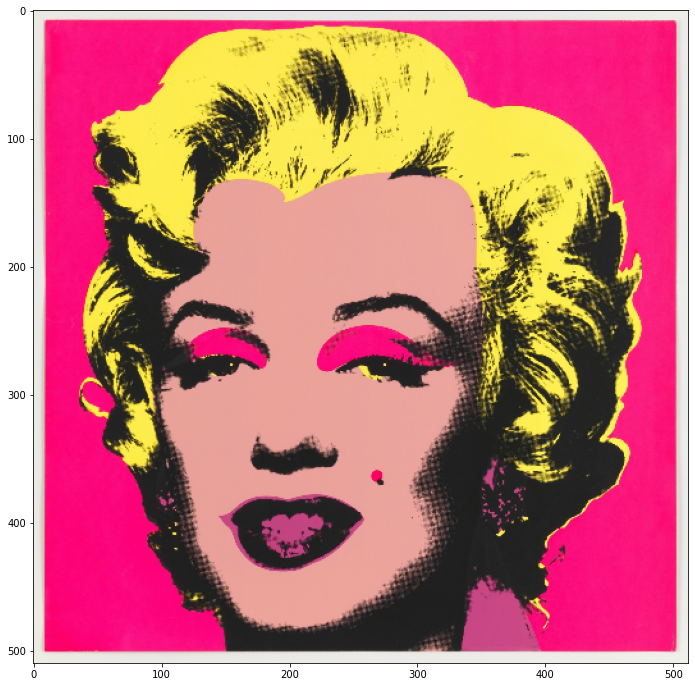

In [5]:
style_image = get_image(style_path)
show(style_image)

## Setup the network

The intermediate layers serve as a complex feature extractor. By accessing intermediate layers of the model, we will be able to describe the content and style of input images.

In [6]:
# Let's find out the names of content_layers and style_layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
# closer to output
content_layers = ['block5_conv2']   

# throughout the stack
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1'
]

## Build the style extractor

In [8]:
""" 
Creates a vgg model that returns a list of intermediate output values.
"""

def vgg_model(layer_names):
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg_net = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_net.trainable = False

    outputs = [vgg_net.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg_net.input], outputs)
    
    return model


In [9]:
style_extractor = vgg_model(style_layers)
style_outputs = style_extractor(style_image * 255)

## Extract style and content

The style of an image can be described by the means and correlations across the different feature maps. All we need is to calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations:

In [10]:
"""
This function takes the outer product of the feature vector with itself.
"""
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    return result / (num_locations)

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0013778557
    max:  39913.953
    mean:  489.2063

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  58581.59
    mean:  11397.6

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  239110.61
    mean:  9768.37

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3234475.5
    mean:  154438.11

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  84831.22
    mean:  983.5061

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  1297.4644
    mean:  11.284133


## Run gradient descent

With style and content extractors, we can now implement the style transfer algorithm. We can do that by calculating the mean square error for the image's output relative to each target, then take the weighted sum of these losses.

In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Now we can define a tf.Variable to contain the image to optimize. To make this quick, we can initialize it with the content image (the tf.Variable must be the same shape as the content image):

In [14]:
image = tf.Variable(content_image)

# Since this is a float image, define a function to keep the pixel values between 0 and 1:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [15]:
# Create an optimizer instanccce, The paper recommends LBFGS, but Adam works too.
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted sum of the two losses to get the total loss:

In [16]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_style_layers = len(style_layers)
    num_content_layers = len(content_layers)
    
    style_loss = tf.add_n(
        [tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
         for name in style_outputs.keys()]
    )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n(
        [tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
         for name in content_outputs.keys()]
    )
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    
    return loss

Now we can use tf.GradientTape to update the image.

In [17]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Now run a few steps to test:

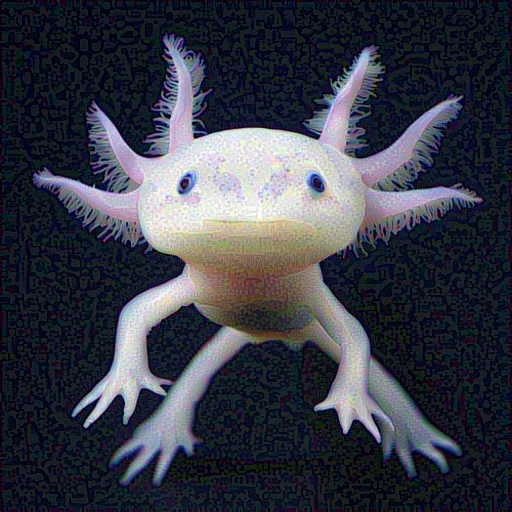

In [18]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

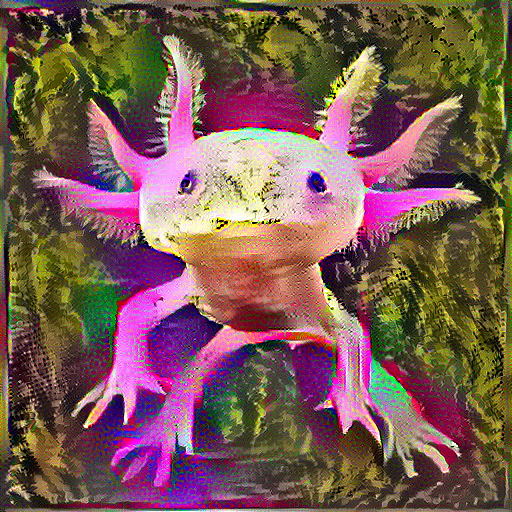

Train step: 1000
Total time: 71.7


In [19]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
